In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

from keras.models import Sequential,Model
from keras.layers import Convolution2D,MaxPool2D,Flatten,Dense,Dropout
from keras.callbacks import TensorBoard
from keras.applications import VGG16
from keras import models,layers,optimizers
from keras.utils import to_categorical


import matplotlib.pyplot as plt
import matplotlib as mpl

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
from sklearn.model_selection import GridSearchCV

In [3]:
def load_datest(feature,dim):
    #
    x_r = np.load('raw_data.npy')
    label_r = np.load('label.npy')
    y_r = label_r[:,feature]
    x_s = np.load('test_raw_data.npy')
    label_s = np.load('test_label.npy')
    y_s = label_s[:,feature]
    X = np.vstack((x_r,x_s))
    Y = np.append(y_r,y_s)
    #数据归一化
    mean_px = X.mean().astype(np.float32)
    std_px = X.std().astype(np.float32)
    X = (X-mean_px)/std_px
    #划分数据
    if dim ==1 :
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=2,test_size = 0.2)
    elif dim == 3:
        X = np.squeeze(X)
        X3 = np.zeros([X.shape[0],X.shape[1],X.shape[2],3])
        X3[:,:,:,0] = X
        X3[:,:,:,1] = X
        X3[:,:,:,2] = X
        X_train, X_test, Y_train, Y_test = train_test_split(X3, Y, random_state=2,test_size = 0.2)
    return X_train, X_test, Y_train, Y_test

In [4]:
def vgg_model():
    conv_base=VGG16(weights='imagenet',include_top=False,input_shape=(128,128,3))
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(layers.Dense(3, activation='softmax'))

    conv_base.trainable=False
    model.summary()
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['acc'])
    return model

In [5]:
def cnn_model2():
    model = Sequential()

    model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (128,128,1)))
    model.add(Convolution2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
    model.add(Convolution2D(filters = 64, kernel_size = (3,3),padding = 'Same',
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation = "softmax"))
    model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])
    model.summary()
    return model

In [6]:
def show(history):
    history_dict = history.history
    history_dict.keys()
    loss_value = history_dict["loss"]
    val_loss_values = history_dict['val_loss']
    epochs = range(1,len(loss_value)+1)
    plt.plot(epochs, loss_value,'bo')
    plt.plot(epochs, val_loss_values, 'b+')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    print(loss_value)
    return 1

In [7]:
def plot_auc(y_p,y_test):
    #画AUC  注意输入前需要进行one_hot_coding
    fpr, tpr, thresholds = metrics.roc_curve(y_p.ravel(), y_test.ravel())
    auc = metrics.auc(fpr, tpr)
    mpl.rcParams['font.sans-serif'] = u'SimHei'
    mpl.rcParams['axes.unicode_minus'] = False
    #FPR就是横坐标,TPR就是纵坐标
    plt.plot(fpr, tpr, c = 'r', lw = 2, alpha = 0.7, label = u'AUC=%.3f' % auc)
    plt.plot((0, 1), (0, 1), c = '#808080', lw = 1, ls = '--', alpha = 0.7)
    plt.xlim((-0.01, 1.02))
    plt.ylim((-0.01, 1.02))
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xlabel('False Positive Rate', fontsize=13)
    plt.ylabel('True Positive Rate', fontsize=13)
    plt.grid(b=True, ls=':')
    plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)

## vgg

In [6]:
epochs = 5
dim = 3
weight_name ='weight/vgg_weight.h5'

In [6]:
X_train, X_test, Y_train, Y_test =load_datest(4,dim)
Y_test = to_categorical(Y_test)
Y_train = to_categorical(Y_train)

In [10]:
model = vgg_model()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
#model2 = cnn_model2()

In [14]:
history = model.fit(X_train,Y_train,epochs=epochs,validation_data=(X_test,Y_test), shuffle=False)

Train on 3194 samples, validate on 799 samples
Epoch 1/5
3194/3194 [==============================] - 214s 67ms/step - loss: 0.4369 - acc: 0.7829 - val_loss: 0.4854 - val_acc: 0.7330
Epoch 2/5
3194/3194 [==============================] - 215s 67ms/step - loss: 0.4315 - acc: 0.7891 - val_loss: 0.5061 - val_acc: 0.7292
Epoch 3/5
3194/3194 [==============================] - 215s 67ms/step - loss: 0.4171 - acc: 0.7900 - val_loss: 0.5101 - val_acc: 0.7393
Epoch 4/5
3194/3194 [==============================] - 207s 65ms/step - loss: 0.4147 - acc: 0.7956 - val_loss: 0.5018 - val_acc: 0.7514
Epoch 5/5
3194/3194 [==============================] - 222s 69ms/step - loss: 0.4039 - acc: 0.7998 - val_loss: 0.4785 - val_acc: 0.7647


In [17]:
model.save_weights(weight_name)

In [18]:
model2 = vgg_model()
model.load_weights(weight_name)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 771       
Total params: 16,812,867
Trainable params: 2,098,179
Non-trainable params: 14,714,688
_________________________________________________________________


In [20]:
dense1_layer_model = Model(inputs=model.input,outputs=model.layers[-2].output)

In [21]:
X_train = dense1_layer_model.predict(X_train)

In [ ]:
X_test2 = dense1_layer_model.predict(X_test)

# cnn -----cnn -----cnn -----cnn -----cnn -----cnn -----cnn -----cnn -----cnn -----

In [118]:
model2 = cnn_model2()
dim =1 
X_train, X_test, Y_train, Y_test =load_datest(2,dim)
Y_test_h = to_categorical(Y_test)
Y_train_h = to_categorical(Y_train)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)       

In [119]:
Y_test_h.shape

(799, 4)

In [121]:
history = model2.fit(X_train,Y_train_h,epochs=5,validation_data=(X_test,Y_test_h), shuffle=False)

Train on 3194 samples, validate on 799 samples
Epoch 1/5
3194/3194 [==============================] - 314s 98ms/step - loss: 1.5562 - accuracy: 0.8967 - val_loss: 1.6988 - val_accuracy: 0.8892
Epoch 2/5
3194/3194 [==============================] - 318s 99ms/step - loss: 1.5601 - accuracy: 0.8986 - val_loss: 1.6988 - val_accuracy: 0.8892
Epoch 3/5
3194/3194 [==============================] - 304s 95ms/step - loss: 1.5601 - accuracy: 0.8986 - val_loss: 1.6988 - val_accuracy: 0.8892
Epoch 4/5
3194/3194 [==============================] - 306s 96ms/step - loss: 1.5601 - accuracy: 0.8986 - val_loss: 1.6988 - val_accuracy: 0.8892
Epoch 5/5
 864/3194 [=======>......................] - ETA: 3:27 - loss: 1.6109 - accuracy: 0.8953

KeyboardInterrupt: 

In [122]:
model2.save_weights('weight/cnn_weight2.h5')

In [123]:
model3 = cnn_model2()
model3.load_weights('weight/cnn_weight2.h5')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)       

In [136]:
#训练？？？？
#model3.fit(X_train,Y_train_h,epochs=1,validation_data=(X_test,Y_test_h), shuffle=False)

In [135]:
yp = model3.predict_classes(X_test)

### cnn 模型评估

In [ ]:
yp_h = to_categorical(yp)  #预测结果热编码

In [137]:
#因为热编码后少了一个维度（没有预测到3，实际数据是有3的）所以增加一维
yp = np.zeros(Y_test_h.shape)
yp[:,0:3] = yp_h
plot_auc(Y_test_h,yp)

0.7784730913642053

### cnn 模型输出保存

In [127]:
# cnn倒数第二层输出
dense1_layer_model = Model(inputs=model3.input,outputs=model3.layers[-2].output)
X_rtemp = dense1_layer_model.predict(X_train)
X_stemp = dense1_layer_model.predict(X_test)

In [128]:
np.save('cnn_output/X_rtemp2',X_rtemp)
np.save('cnn_output/X_stemp2',X_stemp)
np.save('cnn_output/Y_train2',Y_train)
np.save('cnn_output/Y_test2',Y_test)
np.save('cnn_output/X_train2',X_train)
np.save('cnn_output/X_test2',X_test)

# xgboost-----xgboost-----xgboost-----xgboost-----xgboost-----xgboost

In [10]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV,KFold,RandomizedSearchCV
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import classification_report

#Y_test_h 有热编码    Y_train_h
#Y_test  无热编码      Y_test
#X_rtemp cnn输出训练集 
#X_stemp cnn输出测试
#X_train   X_test

In [11]:
X_rtemp = np.load('cnn_output/X_rtemp2.npy')
X_stemp = np.load('cnn_output/X_stemp2.npy')
Y_train = np.load('cnn_output/Y_train2.npy')
Y_test = np.load('cnn_output/Y_test2.npy')

In [12]:
print(X_rtemp.shape)
print(X_stemp.shape)
print(Y_train.shape)
print(Y_test.shape)

(3194, 256)
(799, 256)
(3194,)
(799,)


# 初始化参数


In [84]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0.1,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
    
 scale_pos_weight=1,
 seed=27)

In [85]:
xgb1.fit(X_rtemp,Y_train)

[11:15:47] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.1, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=27, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [86]:
xgb1.score(X_stemp,Y_test)

0.7922403003754693

#   参数调优

In [30]:
def plot_score2(A,B,A_name,B_name,gsearch):
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    print(gsearch.best_params_)
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)) 
              
       
    test_scores = np.array(means).reshape(len(A), len(B))
    print(test_scores)
    for i, value in enumerate(A):
        lines=plt.plot(B, test_scores[i], label= A_name + str(value))
        plt.setp(lines,marker = "o") 
    plt.ylabel( 'accuray' )
    plt.xlabel(B_name)
    plt.grid(True)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 
    plt.show()
    
    
    
def plot_score1(A,A_name,gsearch):
    means = gsearch.cv_results_['mean_test_score']
    stds = gsearch.cv_results_['std_test_score']
    print(gsearch.best_params_)
    for mean, std, params in zip(means, stds, gsearch.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params)) 
    
    lines = plt.plot(A,means)
    plt.setp(lines,marker = "o") 
    plt.ylabel( 'accuray' )
    plt.xlabel(A_name)
    plt.show()


## max_depth 和 min_weight 

先对max_depth和min_child_weight两个参数进行调优，先大范围的进行参数搜索。

max_depth搜索范围为3,6,9,12,15；

min_child_weight 搜索范围为1,4,7,10

In [10]:
max_depth = range(3,15,3)
min_child_weight = range(1,10,3)
param_test1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)

gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                         gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
                       param_grid = param_test1,n_jobs=4,iid=False)
gsearch1.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[09:02:35] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimat...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_metho

{'max_depth': 6, 'min_child_weight': 4}
0.810 (+/-0.013) for {'max_depth': 3, 'min_child_weight': 1}
0.812 (+/-0.011) for {'max_depth': 3, 'min_child_weight': 4}
0.811 (+/-0.010) for {'max_depth': 3, 'min_child_weight': 7}
0.810 (+/-0.016) for {'max_depth': 6, 'min_child_weight': 1}
0.813 (+/-0.016) for {'max_depth': 6, 'min_child_weight': 4}
0.812 (+/-0.018) for {'max_depth': 6, 'min_child_weight': 7}
0.812 (+/-0.012) for {'max_depth': 9, 'min_child_weight': 1}
0.811 (+/-0.016) for {'max_depth': 9, 'min_child_weight': 4}
0.811 (+/-0.020) for {'max_depth': 9, 'min_child_weight': 7}
0.809 (+/-0.011) for {'max_depth': 12, 'min_child_weight': 1}
0.810 (+/-0.019) for {'max_depth': 12, 'min_child_weight': 4}
0.810 (+/-0.014) for {'max_depth': 12, 'min_child_weight': 7}
[[0.81027124 0.81246216 0.81121119]
 [0.80964575 0.81340113 0.81214967]
 [0.81214819 0.8108982  0.81089526]
 [0.8090183  0.80995727 0.80964477]]


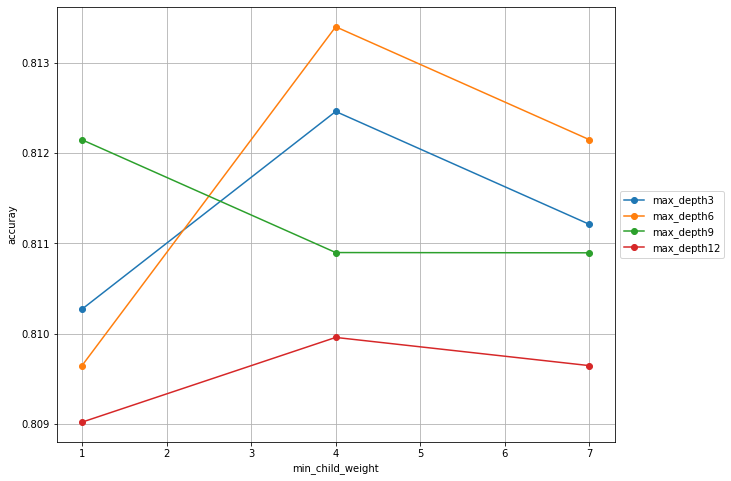

In [12]:
rcParams['figure.figsize'] = 10, 8
plot_score2(max_depth,min_child_weight,'max_depth','min_child_weight',gsearch1)

In [23]:
y_true, y_pred = Y_test, gsearch1.predict(X_stemp)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.56      0.20      0.30        69
           1       0.50      0.14      0.22        63
           2       0.82      0.98      0.89       622
           3       0.64      0.20      0.31        45

    accuracy                           0.80       799
   macro avg       0.63      0.38      0.43       799
weighted avg       0.76      0.80      0.75       799



从上图的大范围搜索得知，比较理想的max_depth为 6 ，min_child_weight为 4。在这些值附近在进行微调，把上限范围各拓展2，进行参数搜索。

In [24]:
max_depth = [4,5,6,7,8]
min_child_weight =  [2,3,4,5,6]
param_test1 = dict(max_depth=max_depth, min_child_weight=min_child_weight)

gsearch11 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                         gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27,cv = 2), 
                       param_grid = param_test1,n_jobs=4,iid=False)
gsearch11.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[09:28:36] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { cv, scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, cv=2, gamma=0,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     num_parallel_tree=None,
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
         

{'max_depth': 4, 'min_child_weight': 6}
0.813 (+/-0.013) for {'max_depth': 4, 'min_child_weight': 2}
0.811 (+/-0.010) for {'max_depth': 4, 'min_child_weight': 3}
0.814 (+/-0.011) for {'max_depth': 4, 'min_child_weight': 4}
0.813 (+/-0.011) for {'max_depth': 4, 'min_child_weight': 5}
0.817 (+/-0.012) for {'max_depth': 4, 'min_child_weight': 6}
0.811 (+/-0.017) for {'max_depth': 5, 'min_child_weight': 2}
0.811 (+/-0.013) for {'max_depth': 5, 'min_child_weight': 3}
0.810 (+/-0.017) for {'max_depth': 5, 'min_child_weight': 4}
0.811 (+/-0.011) for {'max_depth': 5, 'min_child_weight': 5}
0.812 (+/-0.018) for {'max_depth': 5, 'min_child_weight': 6}
0.809 (+/-0.017) for {'max_depth': 6, 'min_child_weight': 2}
0.811 (+/-0.019) for {'max_depth': 6, 'min_child_weight': 3}
0.813 (+/-0.016) for {'max_depth': 6, 'min_child_weight': 4}
0.810 (+/-0.015) for {'max_depth': 6, 'min_child_weight': 5}
0.810 (+/-0.018) for {'max_depth': 6, 'min_child_weight': 6}
0.809 (+/-0.012) for {'max_depth': 7, 'min_ch

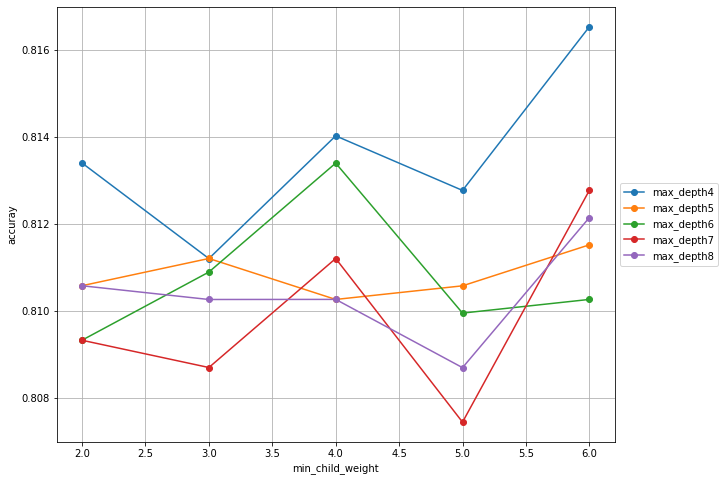

In [28]:
plot_score2(max_depth,min_child_weight,'max_depth','min_child_weight',gsearch11)

从上图微调得到，理想的max_depth为？？？，min_child_weight为？？？,暂且确定这2个参数，进行下一步搜索。

In [30]:
gsearch11.score(X_stemp,Y_test)

0.7959949937421777

# gamma参数调优
gamma

在节点分裂时，只有分裂后损失函数的值下降了，才会分裂这个节点。Gamma指定了节点分裂所需的最小损失函数下降值。

这个参数的值越大，算法越保守。这个参数的值和损失函数息息相关，所以是需要调整的。


在其他已经调整好的参数基础上，我们进行Gamma参数调优。在这Gamma的参数取值为0,0.1,0.2,0.3,0.4,0.5,0.6。

In [51]:
gamma = [i/10.0 for i in range(0,6)]
max_depth = [4]
min_child_weight = [6]
param_test3 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight)

In [53]:
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test3,n_jobs=4,iid=False)
gsearch3.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[10:10:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_esti...
                                     objective='binary:logistic',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=0.8, tree_metho

{'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6}
0.817 (+/-0.012) for {'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 6}
0.817 (+/-0.016) for {'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6}
0.814 (+/-0.011) for {'gamma': 0.2, 'max_depth': 4, 'min_child_weight': 6}
0.815 (+/-0.011) for {'gamma': 0.3, 'max_depth': 4, 'min_child_weight': 6}
0.816 (+/-0.012) for {'gamma': 0.4, 'max_depth': 4, 'min_child_weight': 6}
0.815 (+/-0.012) for {'gamma': 0.5, 'max_depth': 4, 'min_child_weight': 6}


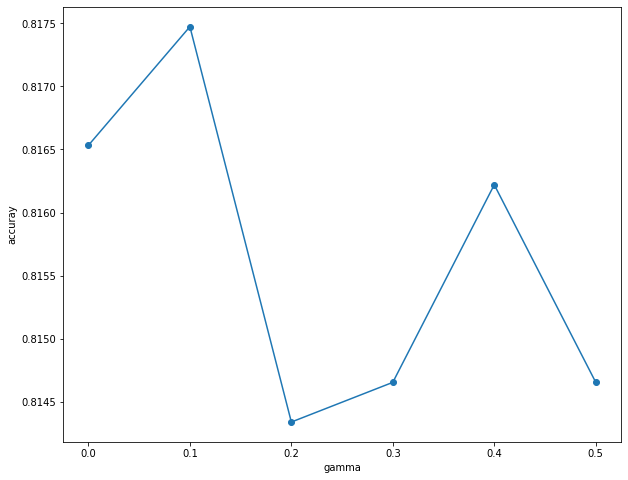

In [57]:
plot_score1(gamma,'gamma',gsearch3)

In [58]:
gsearch3.score(X_stemp,Y_test)

0.7947434292866082

## 调整subsample 和 colsample_bytree 参数

In [61]:
subsample = [i/10.0 for i in range(6,10)]
colsample_bytree  = [i/10.0 for i in range(6,10)]
max_depth = [4]
min_child_weight = [6]
gamma = [0.1]
param_test4 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree)

In [62]:
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                       param_grid = param_test4,n_jobs=4,iid=False)
gsearch4.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[10:27:43] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid=False, n_jobs=4,
             pa

{'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8}
0.811 (+/-0.017) for {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6}
0.809 (+/-0.013) for {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7}
0.814 (+/-0.012) for {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8}
0.813 (+/-0.012) for {'colsample_bytree': 0.6, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.9}
0.812 (+/-0.019) for {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6}
0.813 (+/-0.019) for {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7}
0.813 (+/-0.016) for {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.8}
0.811 (+/-0.013) for {'colsample_bytree': 0.7, 'gamma': 0.1, 'max_depth': 4, 

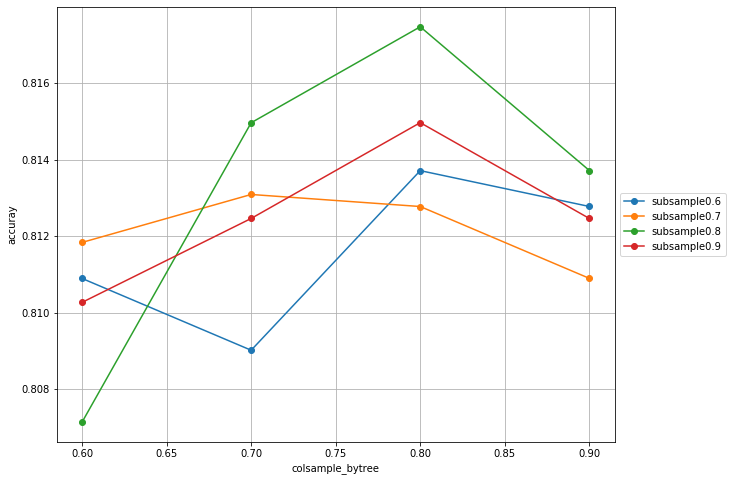

In [64]:
plot_score2(subsample,colsample_bytree,'subsample','colsample_bytree',gsearch4)

## 正则化参数调优
应用正则化来降低过拟合

In [70]:
subsample = [0.8]
colsample_bytree  =[0.8]
max_depth = [4]
min_child_weight = [6]
gamma = [0.1]
reg_alpha = [1e-5, 1e-2, 0.1, 1, 100]
param_test5 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_alpha=reg_alpha)

In [71]:
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test5,n_jobs=4,iid=False)
gsearch5.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[10:35:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid=False, n_jobs=4,
             pa

{'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 1, 'subsample': 0.8}
0.817 (+/-0.016) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 1e-05, 'subsample': 0.8}
0.811 (+/-0.011) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 0.01, 'subsample': 0.8}
0.815 (+/-0.012) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 0.1, 'subsample': 0.8}
0.818 (+/-0.016) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 1, 'subsample': 0.8}
0.797 (+/-0.001) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'reg_alpha': 100, 'subsample': 0.8}


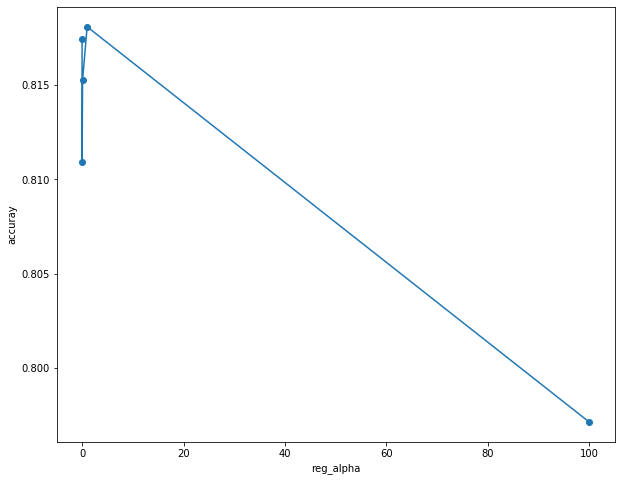

In [73]:
plot_score1(reg_alpha,'reg_alpha',gsearch5)

In [74]:
gsearch5.score(X_stemp,Y_test)

0.7934918648310388

## 调n_estimators

In [78]:
n_estimators =range(100,1400,100)
subsample = [0.8]
colsample_bytree  =[0.8]
max_depth = [4]
min_child_weight = [6]
gamma = [0.1]
reg_alpha = [1]
param_test6 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_alpha=reg_alpha,n_estimators=n_estimators)

In [79]:
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test6,n_jobs=4,iid=False)
gsearch6.fit(X_rtemp,Y_train)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


[11:11:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { scale_pos_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     reg_lambda=None, scale_pos_weight=1,
                                     seed=27, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid=False, n_jobs=4,
             pa

{'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'reg_alpha': 1, 'subsample': 0.8}
0.820 (+/-0.017) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 100, 'reg_alpha': 1, 'subsample': 0.8}
0.815 (+/-0.015) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 200, 'reg_alpha': 1, 'subsample': 0.8}
0.813 (+/-0.019) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 300, 'reg_alpha': 1, 'subsample': 0.8}
0.813 (+/-0.019) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 400, 'reg_alpha': 1, 'subsample': 0.8}
0.814 (+/-0.014) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_weight': 6, 'n_estimators': 500, 'reg_alpha': 1, 'subsample': 0.8}
0.814 (+/-0.011) for {'colsample_bytree': 0.8, 'gamma': 0.1, 'max_depth': 4, 'min_child_wei

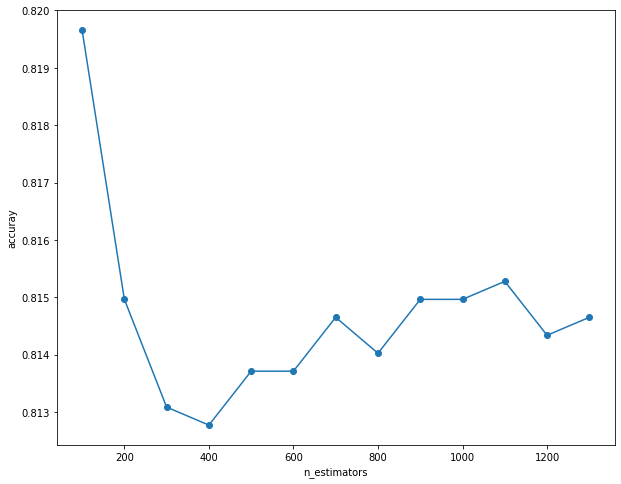

In [82]:
plot_score1(n_estimators,'n_estimators',gsearch6)

## 学习率

In [24]:
n_estimators = [100]
learning_rate = [0.01,0.1,1]
subsample = [0.8]
colsample_bytree  =[0.8]
max_depth = [4]
min_child_weight = [6]
gamma = [0.1]
reg_alpha = [1]
param_test7 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_alpha=reg_alpha,n_estimators=n_estimators,learning_rate =learning_rate)

In [ ]:
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test7,n_jobs=4,iid=False)
gsearch7.fit(X_rtemp,Y_train)

In [ ]:
plot_score1(learning_rate,'learning_rate',gsearch7)

# 评估

In [88]:
y_true, y_pred = Y_test, gsearch6.predict(X_stemp)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.43      0.14      0.22        69
           1       0.58      0.11      0.19        63
           2       0.81      0.98      0.89       622
           3       0.67      0.18      0.28        45

    accuracy                           0.79       799
   macro avg       0.62      0.35      0.39       799
weighted avg       0.75      0.79      0.74       799



In [ ]:
y_ph = to_categorical(y_pred)
y_th = to_categorical(Y_test)
plot_auc(y_ph,y_th)




#  -----------------------------------------------性别预测-----------------------------------------------


In [8]:
X_train2, X_test2, Y_train2, Y_test2 = load_datest(1,1)

In [90]:
model3 = cnn_model2()
model3.load_weights('weight/cnn_weight2.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      832       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)       

In [93]:
dense1_layer_model = Model(inputs=model3.input,outputs=model3.layers[-2].output)
X_rtemp2 = dense1_layer_model.predict(X_train2)
X_stemp2 = dense1_layer_model.predict(X_test2)

In [94]:
np.save('cnn_output/X_rtemp_gender',X_rtemp2)
np.save('cnn_output/X_stemp_gender',X_stemp2)
np.save('cnn_output/Y_train_gender',Y_train2)
np.save('cnn_output/Y_test_gender',Y_test2)
np.save('cnn_output/X_train_gender',X_train2)
np.save('cnn_output/X_test_gender',X_test2)

In [13]:
#l重新加载数据
X_rtemp2 = np.load('cnn_output/X_rtemp_gender.npy')
X_stemp2 = np.load('cnn_output/X_stemp_gender.npy')
Y_train2 =  np.load('cnn_output/Y_train_gender.npy')
Y_test2  =  np.load('cnn_output/Y_test_gender.npy')

In [14]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
    
 scale_pos_weight=1,
 seed=26)

In [15]:
xgb2.fit(X_rtemp2,Y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=4, nthread=4, num_parallel_tree=1,
              objective='binary:logistic', random_state=26, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=26, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
n_estimators = [1000]
learning_rate = [0.1]
subsample = [0.8]
colsample_bytree  =[0.8]
max_depth = [5]
min_child_weight = [1]
gamma = [0]

param_test7 = dict(gamma = gamma,max_depth=max_depth,min_child_weight=min_child_weight,subsample=subsample,colsample_bytree=colsample_bytree,
                             reg_alpha=reg_alpha,n_estimators=n_estimators,learning_rate =learning_rate)

In [27]:
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, 
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test7,n_jobs=4,iid=False)
gsearch7.fit(X_rtemp2,Y_train2)

f:\py\lib\site-packages\sklearn\model_selection\_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


GridSearchCV(cv=None, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_est...
                                     seed=27, subsample=None, tree_method=None,
                                     validate_parameters=None, verbosity=None),
             iid=False, n_jobs=4,
             param_grid={'colsample_bytree': [0.8], 'gamma': [0],
                       

{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 1, 'subsample': 0.8}
0.709 (+/-0.025) for {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 1000, 'reg_alpha': 1, 'subsample': 0.8}


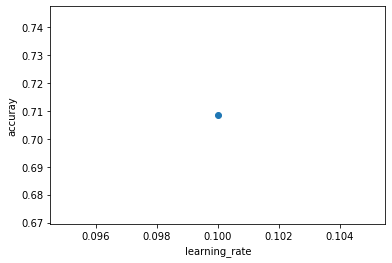

In [31]:
plot_score1(learning_rate,'learning_rate',gsearch7)

In [ ]:
means = gsearch.cv_results_['mean_test_score']
stds = gsearch.cv_results_['std_test_score']

In [123]:
xgb2.score(X_stemp2,Y_test2)

0.7284105131414268

In [124]:
y_true, y_pred = Y_test2, xgb2.predict(X_stemp2)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.56      0.62       317
           1       0.74      0.84      0.79       482

    accuracy                           0.73       799
   macro avg       0.72      0.70      0.70       799
weighted avg       0.72      0.73      0.72       799



In [ ]:
plot_auc(y_pred,y_true)

In [30]:
import matplotlib.pyplot as plt

In [9]:
X_test2.shape

(799, 128, 128, 1)

In [16]:
yp = xgb2.predict(X_stemp2)

In [26]:
num = np.where(yp != Y_test2)[0]
num

array([  1,  10,  17,  18,  19,  22,  25,  26,  30,  34,  35,  37,  52,
        55,  56,  59,  60,  64,  70,  71,  75,  86,  93,  99, 102, 109,
       111, 113, 123, 124, 128, 130, 131, 133, 134, 137, 149, 153, 156,
       159, 160, 162, 165, 168, 169, 171, 174, 182, 185, 186, 188, 197,
       201, 208, 209, 214, 218, 223, 224, 225, 234, 235, 236, 244, 246,
       250, 258, 262, 267, 268, 272, 273, 274, 280, 287, 289, 291, 295,
       296, 303, 305, 306, 307, 309, 311, 314, 317, 320, 323, 326, 329,
       330, 337, 338, 345, 352, 354, 355, 356, 361, 370, 375, 376, 378,
       381, 383, 387, 398, 403, 407, 417, 418, 431, 436, 438, 439, 444,
       445, 450, 455, 456, 457, 459, 460, 461, 463, 465, 466, 468, 482,
       491, 492, 493, 495, 500, 508, 514, 515, 516, 522, 527, 541, 546,
       550, 553, 554, 555, 562, 563, 564, 568, 575, 586, 595, 596, 597,
       601, 603, 604, 607, 612, 623, 625, 633, 642, 643, 645, 647, 649,
       650, 651, 657, 658, 659, 671, 673, 675, 677, 682, 683, 68

In [29]:
X_test2[10,:,:,:]

(128, 128, 1)

In [43]:
Y_test2[10]

1

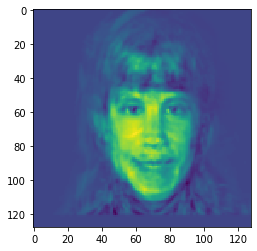

In [35]:
plt.imshow(np.squeeze(X_test2[num[1],:,:,:]))

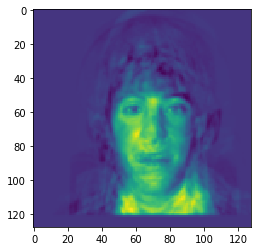

In [50]:
plt.imshow(np.squeeze(X_test2[num[59],:,:,:]))

In [51]:
Y_test2[59]

0

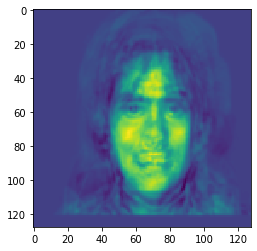

In [65]:
plt.imshow(np.squeeze(X_test2[num[150],:,:,:]))

In [45]:
Y_test2[75]

1